# ResNet usando PyTorch Lightning

- Entrenamiento de Dog Emotion



## Cargar base de datos


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("danielshanbalico/dog-emotion")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1


## Cargar Librerias

In [ ]:
!pip install lightning

  Using cached lightning-2.5.0.post0-py3-none-any.whl.metadata (40 kB)
  Using cached torchmetrics-1.6.1-py3-none-any.whl.metadata (21 kB)
  Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl.metadata (21 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached lightning-2.5.0.post0-py3-none-any.whl (815 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl (207.5 MB)
Using cached torchmetrics-1.6.1-py3-none-any.whl (927 kB)
Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl (819 kB)
  Attempting uninstall: nvidia-cusparse-c

In [ ]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics

from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



## Preprocesamiento

In [ ]:
df = pd.read_csv("imagenes_procesadas_para_modelamiento.csv")
df.head(2)

,file_name,tensor,label,hash,contiene_perro,subset
0,09dUVMcjCDfOtbeYDQg5Fvu3GPHWJg811.jpg,"tensor([[[0.0039, 0.0118, 0.0000, ..., 0.0039...",angry,4da78b5b3b24c75e9b2fb40c938aab57,True,train
1,0AvKtuzA7LfxnKaO0bey9mQMLnxXad73.jpg,"tensor([[[0.4118, 0.4118, 0.4157, ..., 0.0941...",angry,14822cd502ec2c6a8c320f046a22b7e4,True,train


In [ ]:
# Crear la nueva columna 'clase' con el mismo contenido que 'label'
df['clase'] = df['label']

# Codificar 'label' en valores numéricos
df['label'] = df['label'].astype('category').cat.codes

# Mostrar los primeros registros para verificar
df.head()

,file_name,tensor,label,hash,contiene_perro,subset,clase
0,09dUVMcjCDfOtbeYDQg5Fvu3GPHWJg811.jpg,"tensor([[[0.0039, 0.0118, 0.0000, ..., 0.0039...",0,4da78b5b3b24c75e9b2fb40c938aab57,True,train,angry
1,0AvKtuzA7LfxnKaO0bey9mQMLnxXad73.jpg,"tensor([[[0.4118, 0.4118, 0.4157, ..., 0.0941...",0,14822cd502ec2c6a8c320f046a22b7e4,True,train,angry
2,0C5yo7GxMy8lztxNZvSdfEx2gSPRTR701.jpg,"tensor([[[0.0078, 0.0078, 0.0039, ..., 0.0039...",0,10a5f619c8bd0bf549e468c4e333d9fd,False,train,angry
3,0C9jEgFQHsh36W5U2u5CA98lB7C5eX806.jpg,"tensor([[[0.0039, 0.0000, 0.0039, ..., 0.0039...",0,4d7fc66574d4a5c67471c6b7a8b6d604,True,train,angry
4,0RXraPIKC00Dz1qkuMbj8XbuR80g5Z893.jpg,"tensor([[[0.0039, 0.0039, 0.0078, ..., 0.0078...",0,2ed31cdf98d5dc6882cc26b0341e287d,True,train,angry


In [ ]:
print(df[['clase', 'label']].drop_duplicates().sort_values('label'))

        clase  label
0       angry      0
998     happy      1
1998  relaxed      2
2998      sad      3


In [ ]:

# Ruta ajustada al directorio de las imágenes
dataset_path = os.path.join(path, "Dog Emotion")
dataset_path

'/root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1/Dog Emotion'

## Primer Acercamiento Datos

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import glob  # Para buscar en subdirectorios


# Transformaciones para imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar imágenes a 128x128 píxeles
    transforms.ToTensor(),         # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar valores de píxeles
])

# Función para encontrar la ruta real de una imagen en subcarpetas
def find_image_path(image_name, root_dir):
    """Busca la imagen en todas las subcarpetas y devuelve la ruta completa."""
    for root, _, files in os.walk(root_dir):
        if image_name in files:
            return os.path.join(root, image_name)
    return None  # Retorna None si no se encuentra

# Clase Dataset personalizada
class CustomDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["file_name"]
        label = self.df.iloc[idx]["label"]

        # Buscar la imagen en las subcarpetas
        img_path = find_image_path(img_name, self.root_dir)
        if img_path is None:
            raise FileNotFoundError(f"No se encontró la imagen: {img_name}")

        # Cargar imagen
        image = Image.open(img_path).convert("RGB")

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label

# Filtrar datos de entrenamiento y prueba
train_df = df[df["subset"] == "train"]
test_df = df[df["subset"] == "test"]

# Crear datasets
train_dataset = CustomDataset(train_df, dataset_path, transform)
test_dataset = CustomDataset(test_df, dataset_path, transform)

# Crear DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)



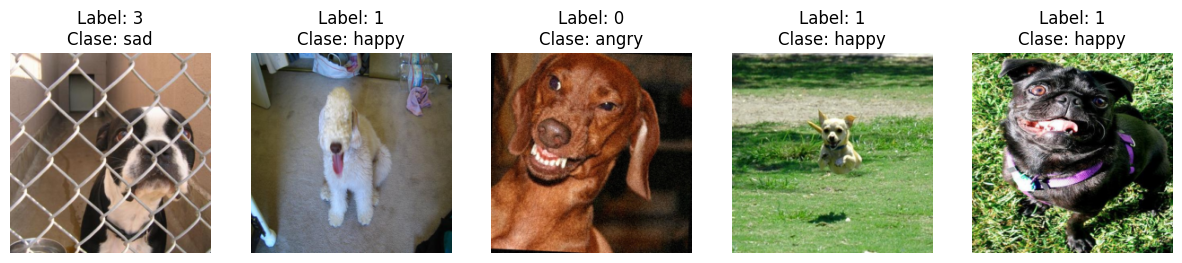

In [ ]:
# Obtener un batch de imágenes y labels del train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Obtener los nombres de las clases
label_to_class = dict(zip(train_df['label'], train_df['clase']))
label_to_class = {k: v for k, v in sorted(label_to_class.items())}  # Ordenar por índice

# Mostrar 5 imágenes con sus etiquetas
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()  # Convertir de tensor a numpy
    img = (img * 0.5) + 0.5  # Desnormalizar

    label_num = labels[i].item()
    label_name = label_to_class[label_num]

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label_num}\nClase: {label_name}")
    axes[i].axis("off")

plt.show()


In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 3, 1, 1, 1, 0, 3, 1, 3, 2, 3, 1, 0, 1, 1, 1, 1, 0, 3, 1, 2, 0,
        0, 3, 2, 2, 0, 3, 3, 2], dtype=torch.int8)


## Modelamiento

### Hiperparámetros de la red

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 0.0000001
NUM_WORKERS = 4 # unidades de procesamiento o hilos
CLASES = 4

### DataModule para Lightning

In [ ]:
import os
import pandas as pd
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# Transformaciones para imágenes
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Función para encontrar la ruta real de una imagen en subcarpetas
def find_image_path(image_name, root_dir):
    """Busca la imagen en todas las subcarpetas y devuelve la ruta completa."""
    for root, _, files in os.walk(root_dir):
        if image_name in files:
            return os.path.join(root, image_name)
    return None  # Retorna None si no se encuentra

# Dataset personalizado
class DogEmotionDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["file_name"]
        label = int(self.df.iloc[idx]["label"])  # Asegurar que sea un entero antes de convertirlo en tensor
        label = torch.tensor(label, dtype=torch.long)

        img_path = find_image_path(img_name, self.root_dir)
        if img_path is None:
            raise FileNotFoundError(f"No se encontró la imagen: {img_name}")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# DataModule para PyTorch Lightning
class DogEmotionDataModule(pl.LightningDataModule):
    def __init__(self, csv_path, dataset_path, batch_size=32, num_workers=2):
        super().__init__()
        self.csv_path = csv_path
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.df = None  # Definir el dataframe en setup()

    def setup(self, stage=None):
        """Carga el dataset y lo divide en train, validación y test."""
        self.df = pd.read_csv(self.csv_path)

        # Asegurar que label es numérico
        if not pd.api.types.is_integer_dtype(self.df["label"]):
            self.df["label"] = self.df["label"].astype("category").cat.codes

        train_df = self.df[self.df["subset"] == "train"]
        test_df = self.df[self.df["subset"] == "test"]

        self.train_dataset = DogEmotionDataset(train_df, self.dataset_path, transform=train_transform)
        self.test_dataset = DogEmotionDataset(test_df, self.dataset_path, transform=test_transform)

        # Dividir en entrenamiento y validación (90% - 10%)
        train_size = int(0.9 * len(self.train_dataset))
        valid_size = len(self.train_dataset) - train_size
        self.train_dataset, self.valid_dataset = random_split(self.train_dataset, [train_size, valid_size])

        print(f"Entrenamiento: {train_size}, Validación: {valid_size}, Test: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

# Inicializar el DataModule
data_module = DogEmotionDataModule(csv_path="imagenes_procesadas_para_modelamiento.csv", dataset_path="ruta/dataset")

# Preparar y cargar datos
data_module.setup()

# Obtener los DataLoaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()


Entrenamiento: 3236, Validación: 360, Test: 400


In [ ]:
# Inicializar el DataModule
csv_path = "imagenes_procesadas_para_modelamiento.csv"
data_module = DogEmotionDataModule(csv_path, dataset_path)

# Preparar y cargar datos
data_module.prepare_data()
data_module.setup()

# Obtener los DataLoaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()


Entrenamiento: 3236, Validación: 360, Test: 400


In [ ]:
360/(3236+360+400)

0.09009009009009009

In [ ]:
# Inicialización de DataModule
torch.manual_seed(47)  # Fijar una semilla para reproducibilidad

# Inicializar el DataModule con la nueva clase
data_module =  DogEmotionDataModule(csv_path, dataset_path)

# Preparar los datos (transformaciones y verificaciones)
data_module.prepare_data()

# Configurar el dataset para entrenamiento, validación y prueba
data_module.setup(stage='fit')

Entrenamiento: 3236, Validación: 360, Test: 400


### Importar la arquitectura

In [ ]:
pytorch_model = torch.hub.load('pytorch/vision:v0.11.0', 'efficientnet_b0', weights='EfficientNet_B0_Weights.IMAGENET1K_V1')


Downloading: "https://github.com/pytorch/vision/zipball/v0.11.0" to /root/.cache/torch/hub/v0.11.0.zip
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 84.3MB/s]


Modificamos el numero de clases de salida en resnet18

In [ ]:
pytorch_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
pytorch_model.classifier[1] = nn.Linear(in_features=1280, out_features=4)

In [ ]:
# Arquitectura modifica a FASHION MNIST
pytorch_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Seleccionamos el número de capas que van a re-entrenarse

In [ ]:
# Conocer numero de parámetros
for i, param in enumerate(pytorch_model.parameters()):
  i
print(i)


212


In [ ]:
limite = int(i*0.10)
limite

21

In [ ]:
# Congelar las primeras capas de VGG16
threshold = i-limite  # Ajustar según sea necesario
for i, param in enumerate(pytorch_model.parameters()):
    if i < threshold:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [ ]:
20/150

0.13333333333333333

### Definición del Módulo Lightning

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics

class Lightning_CNN(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4, num_classes=4):
        super().__init__()

        self.save_hyperparameters(ignore=["model"])  # Guarda hiperparámetros sin incluir el modelo

        self.model = model
        self.num_classes = num_classes

        # Definición de métricas para cada grupo de datos
        self.train_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task="multiclass")
        self.valid_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task="multiclass")
        self.test_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task="multiclass")

        self.loss_fn = nn.CrossEntropyLoss()  # Función de pérdida para clasificación

    def forward(self, x):
        return self.model(x)

    # Paso compartido para train, val y test
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = self.loss_fn(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)  # Obtener la clase predicha

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        # Registrar loss y accuracy en entrenamiento
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, prog_bar=True)

        return loss  # Este valor se pasa al optimizador

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("valid_loss", loss, on_epoch=True, prog_bar=True)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer


### Entrenamiento del modelo

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar

# Definir hiperparámetros
LEARNING_RATE = 1e-4
CLASES = 4  # Cambiar según el número de clases en Dog Emotion

# Inicializar modelo con MobileNetV2 modificado para 4 clases
lightning_model = Lightning_CNN(
    model=pytorch_model,  # Modelo MobileNetV2 ya ajustado
    learning_rate=LEARNING_RATE,
    num_classes=CLASES
)

# Callbacks para entrenamiento
callback_check = ModelCheckpoint(
    save_top_k=1,  # Guardar solo el mejor modelo
    mode="max",
    monitor="valid_acc",  # Se monitorea la métrica de validación
    filename="best-checkpoint",  # Nombre del archivo del mejor modelo
    save_last=True  # Guarda también la última versión del modelo
)

callback_tqdm = TQDMProgressBar(refresh_rate=20)  # Barra de progreso más limpia

early_stop_callback = EarlyStopping(
    monitor="valid_acc",  # Se monitorea valid_acc para detener el entrenamiento
    patience=10,  # Esperar 10 épocas sin mejora antes de detener el entrenamiento
    mode="max"
)

# Logger para registrar métricas en CSV
logger = CSVLogger(
    save_dir="./logs/",
    name="dog-emotion"
)



In [ ]:
#  Inicia entrenamiento

trainer = pl.Trainer(max_epochs= NUM_EPOCHS,
                    callbacks=[callback_check, callback_tqdm, early_stop_callback],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model = lightning_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Entrenamiento: 3236, Validación: 360, Test: 400


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 4.0 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | valid_acc | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | loss_fn   | CrossEntropyLoss   | 0      | train
---------------------------------------------------------
1.4 M     Trainable params
2.7 M     Non-trainable params
4.0 M     Total params
16.051    Total estimated model params size (MB)
341       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento en minutos: 21.20


Non-trainable params:

*   BatchNorm2d Running Statistics: running_mean and running_var in each batch normalization layer.

## Graficamos las curvas de aprendizaje del modelo

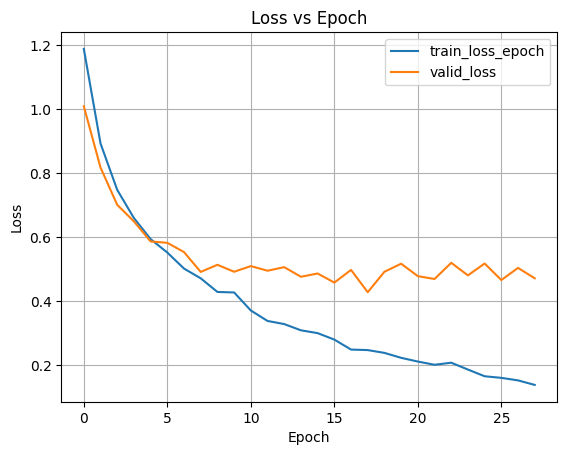

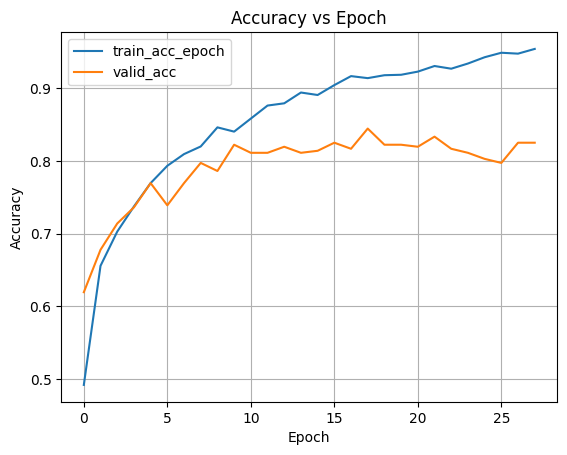

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer métricas del archivo CSV generado por el logger
metrics_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(metrics_path)

# Agregar métricas por época
aggreg_metrics = []
agg_col = "epoch"  # Agrupar por la columna de época
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())  # Calcular la media para todas las métricas por época
    agg[agg_col] = i
    aggreg_metrics.append(agg)

# Convertir a DataFrame para visualización
df_metrics = pd.DataFrame(aggreg_metrics)

# Graficar las pérdidas (loss) para entrenamiento y validación
df_metrics[["train_loss_epoch", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch"
)

# Graficar las precisiones (accuracy) para entrenamiento y validación
df_metrics[["train_acc_epoch", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch"
)

# Mostrar las gráficas
plt.show()


## Evaluamos el mejor modelo en el grupo de test

In [ ]:
# Probar el modelo utilizando el mejor checkpoint guardado
trainer.test(
    model=lightning_model,
    datamodule=data_module,
    ckpt_path=callback_check.best_model_path  # Cargar el mejor modelo guardado automáticamente
)


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt


Entrenamiento: 3236, Validación: 360, Test: 400


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8050000071525574     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8050000071525574}]

In [ ]:
print(f"Mejor modelo guardado en: {callback_check.best_model_path}")


Mejor modelo guardado en: ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt


In [ ]:
df_metrics

,epoch,step,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,valid_acc,valid_loss
0,0,100.333333,0.491965,0.46875,1.187475,1.030229,0.619444,1.008334
1,1,201.666667,0.655748,0.59375,0.892189,0.965144,0.677778,0.816971
2,2,303.000000,0.702719,0.75000,0.747248,0.632881,0.713889,0.700488
3,3,404.333333,0.737330,0.62500,0.659291,0.904432,0.736111,0.648907
4,4,505.666667,0.769468,0.75000,0.593450,0.509470,0.769444,0.586254
5,5,607.000000,0.793263,0.84375,0.551565,0.450509,0.738889,0.581929
6,6,708.333333,0.809332,0.81250,0.501504,0.362495,0.769444,0.552958
7,7,809.666667,0.819839,0.90625,0.471071,0.427011,0.797222,0.491107
8,8,911.000000,0.846106,0.93750,0.428526,0.278453,0.786111,0.513323
9,9,1012.333333,0.840235,0.96875,0.426924,0.238732,0.822222,0.491595


In [ ]:
import torch
import pandas as pd
import sqlite3

# Evaluar el modelo en el conjunto de prueba
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path=callback_check.best_model_path)

# Obtener el dataloader de prueba
test_dataloader = data_module.test_dataloader()

# Listas para almacenar los resultados
predictions = []
labels = []

# Modo evaluación
lightning_model.eval()

# Deshabilitar el cálculo de gradientes para inferencia
with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch  # Obtener imágenes y etiquetas verdaderas

        outputs = lightning_model(inputs)  # Obtener predicciones del modelo

        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

        predictions.extend(predicted.cpu().numpy())  # Guardar predicciones
        labels.extend(targets.cpu().numpy())  # Guardar etiquetas reales

# Crear un DataFrame con los resultados
df_results = pd.DataFrame({"Label": labels, "Prediction": predictions})



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt


Entrenamiento: 3236, Validación: 360, Test: 400


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8050000071525574     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
df_results

,Label,Prediction
0,0,3
1,0,2
2,0,0
3,0,0
4,0,0
...,...,...
395,3,3
396,3,2
397,3,3
398,3,3


In [ ]:
df_results.count()

,0
Label,400
Prediction,400


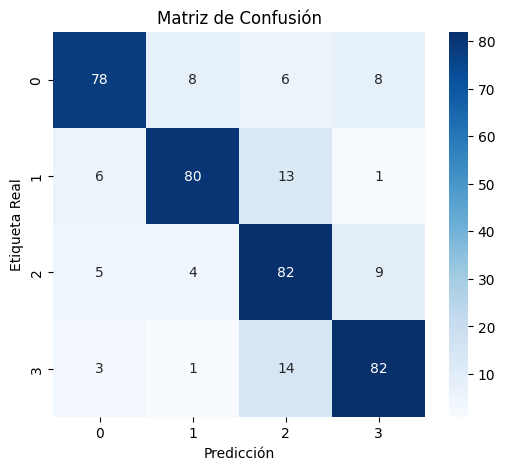

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(df_results["Label"], df_results["Prediction"])

# Crear el heatmap con la matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=set(df_results["Label"]), yticklabels=set(df_results["Label"]))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()


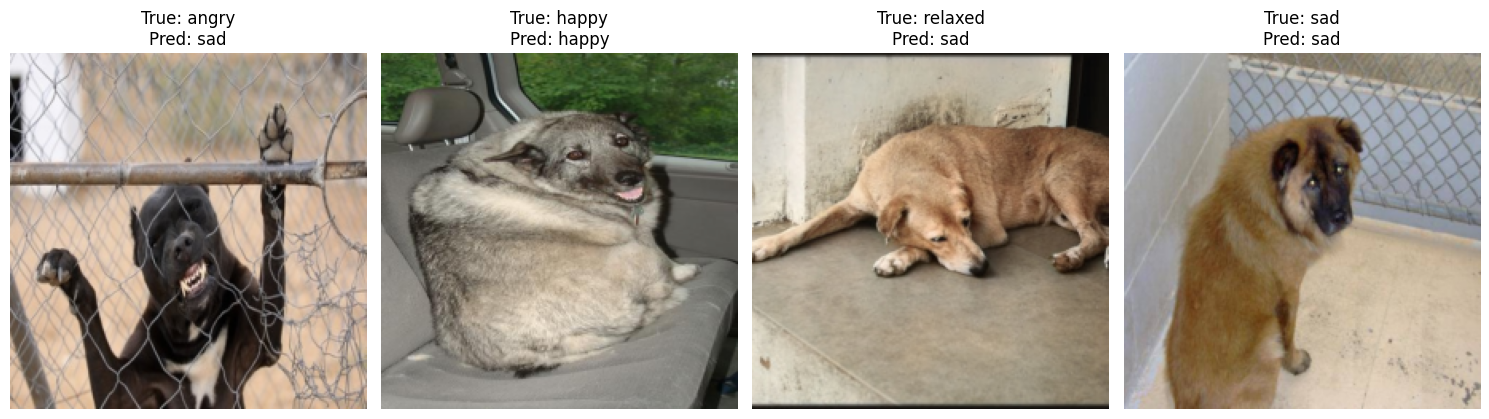

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Mapeo de etiquetas numéricas a nombres de clases
label_to_class = {0: "angry", 1: "happy", 2: "relaxed", 3: "sad"}

# Mean y std de la normalización utilizada en los transform
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

# Inicializar listas para almacenar imágenes, etiquetas verdaderas y predichas
selected_images = {}
selected_true_labels = {}
selected_pred_labels = {}

# Buscar un batch con las 4 clases presentes
for inputs, targets in test_dataloader:
    # Modo evaluación del modelo
    lightning_model.eval()

    # Deshabilitar gradientes para inferencia
    with torch.no_grad():
        outputs = lightning_model(inputs)  # Obtener predicciones del modelo
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

    # Guardar una imagen de cada clase diferente
    for idx, label in enumerate(targets):
        label = label.item()
        if label not in selected_images:
            selected_images[label] = inputs[idx]  # Guardar la imagen
            selected_true_labels[label] = label_to_class[label]  # Etiqueta real
            selected_pred_labels[label] = label_to_class[predicted[idx].item()]  # Predicción del modelo

        # Detener si ya se encontraron las 4 clases
        if len(selected_images) == 4:
            break
    if len(selected_images) == 4:
        break

# Si no se encontraron todas las clases, lanzar un aviso
if len(selected_images) < 4:
    print("No se encontraron imágenes de todas las clases en el test set.")

# Crear la figura
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

for i, (label, img) in enumerate(selected_images.items()):
    ax = axes[i]  # Seleccionar el subplot correspondiente

    # Convertir tensor a numpy y desnormalizar
    img = img.cpu().numpy().transpose(1, 2, 0)  # Convertir a formato (H, W, C)
    img = (img * imagenet_std) + imagenet_mean  # Desnormalizar
    img = np.clip(img, 0, 1)  # Asegurar que está en el rango [0,1]

    # Obtener etiquetas
    true_label_name = selected_true_labels[label]
    predicted_label_name = selected_pred_labels[label]

    # Mostrar la imagen con título
    ax.imshow(img)
    ax.set_title(f"True: {true_label_name}\nPred: {predicted_label_name}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
print(BATCH_SIZE)
print(NUM_EPOCHS)
print(LEARNING_RATE)
print(NUM_WORKERS)
print(CLASES)

16
30
0.0001
4
4


In [ ]:
1+2

3

# Aplicacion

In [46]:
from pathlib import Path

best_model_path = '/content/logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt'

# Ahora sí cargas tu modelo Lightning desde checkpoint con tu modelo base
model_entrenado = Lightning_CNN.load_from_checkpoint(
    checkpoint_path=best_model_path,
    model=pytorch_model
)

model_entrenado.eval()


Lightning_CNN(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [ ]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
from google.colab.patches import cv2_imshow

# Dispositivo de procesamiento (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Envía modelo al dispositivo correcto
model_entrenado = model_entrenado.to(device)
model_entrenado.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

emotion_labels = ['angry', 'happy', 'neutral', 'sad']  # Ajusta según tu caso

video_path = '/content/angry_dog.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error abriendo video.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_frame = Image.fromarray(frame_rgb)

    input_tensor = transform(pil_frame).unsqueeze(0).to(device)  # <-- Envía tensor al mismo dispositivo

    with torch.no_grad():
        outputs = model_entrenado(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        prediction = torch.argmax(probabilities, dim=1)

    emotion = emotion_labels[prediction.item()]
    confidence = probabilities.max().item()

    label_text = f"{emotion} ({confidence*100:.1f}%)"

    cv2.putText(frame, label_text, (30, 40), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2)

    # Mostrar frame usando Colab
    cv2_imshow(frame)

cap.release()
